# Machine Learning for Complete Intersection Calabi-Yau Manifolds

In order to improve the results of the analysis, we employ the _stacking_ procedure to improve the predictions on $h_{11}$ and $h_{21}$. This is an **ensemble** learning technique typically used in competitions. We use:

- [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to see whether **L1** and **L2** can be implemented together,
- [SVR (with Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) to introduce a kernel function,
- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) to use forests of **decision trees** for the predictions,
- Inception-like neural network,

on a first level training set to have predictions on a second level set. We then use a second level (or **meta**) estimator, such as:

- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

on the new predictions.

For this analysis we use the feature engineered dataset.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.12-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       2865 MHz (max: 3800 MHz)
Available RAM memory:        5979 MB (tot: 15758 MB)


For future use, we establish early in the notebook the number of maximum jobs that every algorithm can take concurrently. Thus, if we want to run parallel notebooks with different jobs, we will not encounter issues.

In [2]:
#n_jobs = int(InfoOS().threads) #---------- very intensive but faster
#n_jobs = int(InfoOS().threads / 2) #------ still fast enough but less intensive (only 50% of available threads are occupied)
n_jobs = int(InfoOS().threads / 4) #------ slower

We then print information on the current GPU setup (if available):

In [3]:
!nvidia-smi

Tue May 19 09:39:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   66C    P8    N/A /  N/A |      5MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [4]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Scikit-optimize version: {}'    .format(sko.__version__))
print('Tensorflow version: {}'         .format(tf.__version__))
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.4
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Scikit-optimize version: 0.7.4
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


## Session Preparation

in order to save the results of the analysis, we define where to store images, log files and models:

In [5]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs

DB_NAME = 'cicy3o' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '_analysis.h5' #------------------------------ full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)

We also create a log file to store debug and related information:

In [6]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '_stack.log'
                       )
log = create_logfile(path_to_log,
                     name=DB_NAME + '_stack',
                     level=logging.DEBUG
                    )

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

Rotating existing logs...


2020-05-19 09:39:11,516: INFO ==> New logging session started. Log is at ./log/original/cicy3o_stack.log.


We finally set the _memory growth_ property of the GPU in order to avoid overflowing its RAM memory:

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------------------------------- list of physical GPUs

if gpus: #----------------------------------------------------------------------------------------- set memory growth only if GPU is active
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------------------------------- set memory growth
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') #------------------------ list of logical devices
        print('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus),
                                                                         len(logical_gpus)
                                                                        )
             )
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs in the setup!')

GPU setup: 1 physical GPUs, 1 logical GPUs.


## Loading the Dataset

We first load the dataset we built during the preanalysis.

In [8]:
import pandas as pd

# load the dataset
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    log.debug('Database loaded.')
    log.info('Shape is {:d} rows x {:d} columns.'.format(df.shape[0], df.shape[1]))
else:
    log.error('Cannot load database from {}!'.format(DB_PATH))

2020-05-19 09:39:12,159: DEBUG ==> Database loaded.
2020-05-19 09:39:12,160: INFO ==> Shape is 7851 rows x 7 columns.


We print the `dtypes` and the name of the keys inside the dataframe as a reference:

In [9]:
df.dtypes

h11            int16
h21            int16
num_cp          int8
dim_cp        object
dim_h0_amb    object
matrix        object
pca           object
dtype: object

## Dense Format Extraction

We now extract the needed features from the sparse format in which they are stores. We also contextually build the feature matrices and the labels vectors needed in the analisis.

In [10]:
from mltools.libtransformer import ExtractTensor

# extract the labels
h11        = df['h11'].values
h21        = df['h21'].values

# extract the scalar feature
num_cp     = np.reshape(df['num_cp'].values, (-1,1)) #------------------------------- num_cp needs to be reshaped because it is a single feature

# extract the vector features
dim_cp     = np.array(ExtractTensor(flatten=True).fit_transform(df['dim_cp']))
dim_h0_amb = np.array(ExtractTensor(flatten=True).fit_transform(df['dim_h0_amb']))

# extract the PCA
pca        = np.array(ExtractTensor(flatten=True).fit_transform(df['pca']))

# extract the matrix
matrix = np.array(ExtractTensor(flatten=False).fit_transform(df['matrix'])) #-------- old shape is (batch, width, height)
matrix = np.reshape(matrix, (-1, np.shape(matrix)[1], np.shape(matrix)[2], 1)) #----- new shape is (batch, width, height, 1)

# build the feature engineered sets
feat_h11 = np.c_[num_cp, dim_cp, pca]
feat_h21 = np.c_[num_cp, dim_cp, dim_h0_amb, pca]

## Training and Validation Strategy

We will split the original **full** training set (90% of the total dataset) in two levels (50% of it each) and train the first level estimator on it (using **cross-validation** with 5 splits, such that roughly 9% of the total training set will be used for validation each time). We then keep the final 10% of the dataset as test set. We use Bayesan optimization (from the [_Scikit-optimize_](https://scikit-optimize.github.io/stable/index.html) library) of the hyperparameters as it helps in finding a "direction" in the procedure (as opposed to a random search) and avoids useless grid searches which for large hyperparameter spaces are unfeasible.

In [31]:
from sklearn.model_selection import train_test_split, KFold

# define the cross-validation splits
cv = KFold(n_splits=5, shuffle=True, random_state=RAND)

# divide into training and test sets
feat_h11_train, feat_h11_test, \
feat_h21_train, feat_h21_test, \
matrix_train, matrix_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(feat_h11, feat_h21, matrix, h11, h21,
                                       test_size=0.1,
                                       shuffle=True,
                                       random_state=RAND
                                      )

# split the dataset into two branches
feat_h11_train_lv1, feat_h11_train_lv2, \
feat_h21_train_lv1, feat_h21_train_lv2, \
matrix_train_lv1, matrix_train_lv2, \
h11_train_lv1, h11_train_lv2, \
h21_train_lv1, h21_train_lv2 = train_test_split(feat_h11_train, feat_h21_train, matrix_train, h11_train, h21_train,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=RAND
                                               )

# keep a development set for the matrix at lv1
matrix_train_lv1, matrix_val_lv1, \
h11_matrix_train_lv1, h11_matrix_val_lv1, \
h21_matrix_train_lv1, h21_matrix_val_lv1 = train_test_split(matrix_train_lv1, h11_train_lv1, h21_train_lv1,
                                                            test_size=0.2,
                                                            shuffle=True,
                                                            random_state=RAND
                                                           )

# rescale the matrix
scale_factor     = np.max(matrix_train_lv1) - np.min(matrix_train_lv1)
matrix_train_lv1 = matrix_train_lv1 / scale_factor
matrix_val_lv1   = matrix_val_lv1 / scale_factor
matrix_train_lv2 = matrix_train_lv2 / scale_factor
matrix_test      = matrix_test / scale_factor

# debug info
log.debug('Train set size (lv.1): {:d}'.format(np.shape(feat_h11_train_lv1)[0]))
log.debug('Train set size (lv.2): {:d}'.format(np.shape(feat_h11_train_lv2)[0]))
log.debug('Test set size: {:d}'.format(np.shape(feat_h11_test)[0]))

2020-05-19 20:25:31,064: DEBUG ==> Train set size (lv.1): 3532
2020-05-19 20:25:31,064: DEBUG ==> Train set size (lv.2): 3533
2020-05-19 20:25:31,065: DEBUG ==> Test set size: 786


In the analysis that follows we will then study the accuracy of the algorithms both on validation and test sets and we will plot the predictions made by each algorithm. We will also clearly print the best fitting hyperparameters.

In [12]:
def pretty(dct, indent=True):
    '''
    Pretty print the dictionary of best parameters.
    
    Required argument:
        dct:    the dictionary to pretty print.
        
    Optional argument:
        indent: whether to indent the printed output.
    '''
    
    for key, value in dct.items():
        if indent:
            print('    {} = {}'.format(key, value))
        else:
            print('{} = {}'.format(key, value))

## First Level Training

First of all we train the algorithms on the first level training set and produce the predictions for the second level and the test predictions.

### [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

We start by training an elastic net which implements both **L1** and **L2** regularization. The additional term to the cost function is $\Delta J(\theta) = \alpha L_1 \vert\vert \theta \vert\vert + \frac{1}{2} \alpha (1 - L_1) \vert\vert \theta \vert\vert^2$. In the same way, we could have written $\Delta J(\theta) = a \vert\vert \theta \vert\vert + b \vert\vert  \theta \vert\vert^2$ where $\alpha = a + b$ and $L_1 = \frac{a}{a + b}$. The hyperparameters we control are:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `positive` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-6}, 10^{-1} \right]$,
- `l1_ratio` $\in \left[ 0, 1 \right]$ (the $L_1$ in the previous formulae),
- `selection` $\in \lbrace random, cyclic \rbrace$ (controls whether to update coefficients randomly or looping through the features).

2020-05-19 09:39:16,123: INFO ==> Trainining elastic net...



Best parameters for h11:

    alpha = 0.09991472046372592
    fit_intercept = 0
    l1_ratio = 0.856532553497912
    normalize = 0
    positive = 0
    selection = random

Accuracy of the cross-validation: 62.401% ± 1.584%
Accuracy of the predictions: 64.758%

Best parameters for h21:

    alpha = 2.7714892835448284e-05
    fit_intercept = 1
    l1_ratio = 1.0
    normalize = 1
    positive = 0
    selection = random

Accuracy of the cross-validation: 20.243% ± 1.807%
Accuracy of the predictions: 18.830%


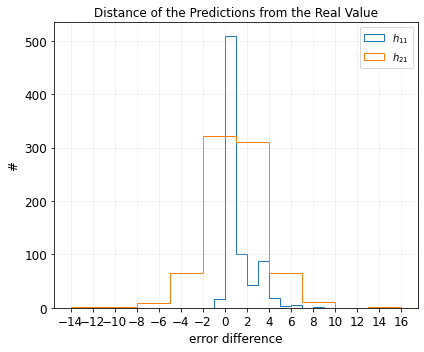

2020-05-19 09:52:33,637: DEBUG ==> Plot saved to ./img/original/el_net_lv1_error.pdf.


In [13]:
from sklearn.linear_model import ElasticNet
from skopt                import BayesSearchCV
from skopt.space          import Integer, Real, Categorical
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Trainining elastic net...')

rounding      = np.floor #----------------------------------------------------------------- choose a rounding function
n_iter        = 50 #----------------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'fit_intercept': Integer(0, 1),
                 'normalize':     Integer(0, 1),
                 'positive':      Integer(0, 1),
                 'l1_ratio':      Real(0.0,    1.0,    prior='uniform'),
                 'alpha':         Real(1.0e-6, 1.0e-1, prior='log-uniform'),
                 'selection':     Categorical(['random', 'cyclic'])
                } #------------------------------------------------------------------------ define the hyperparameter optimization space
estimator     = BayesSearchCV(ElasticNet(max_iter=1e4, tol=1.0e-2, random_state=RAND), #--- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #--------------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

estimator.fit(feat_h11_train_lv1, h11_train_lv1) #----------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

el_net_preds_h11 = estimator.best_estimator_.predict(feat_h11_train_lv2) #----------------------- compute predictions for h11 (lv2)
el_net_test_preds_h11 = estimator.best_estimator_.predict(feat_h11_test) #----------------------- compute predictions for h11 (test)
pred_score_h11  = Score(y_true=h11_test, y_pred=el_net_test_preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_train_lv1, h21_train_lv1) #----------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

el_net_preds_h21 = estimator.best_estimator_.predict(feat_h21_train_lv2) #----------------------- compute predictions for h21 (lv2)
el_net_test_preds_h21 = estimator.best_estimator_.predict(feat_h21_test) #----------------------- compute predictions for h21 (test)
pred_score_h21  = Score(y_true=h21_test, y_pred=el_net_test_preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=1) #----------------------------------------------------------------- plot the comparison of the predictions

plot.hist2D(pred_score_h11.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'el_net_lv1_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'el_net_lv1_error.pdf')))

### [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

We then consider the **support vector machine**. The hyperparameter space is:

- `gamma` $\in \left[ 10^{-3}, 10^3 \right]$,
- `epsilon` $\in \left[ 10^{-2}, 10^2 \right]$ (the $\epsilon$ parameter for the penalty computation),
- `C` $\in \left[ 1, 10^3 \right]$ (the regularization parameter),
- `shrinking` $\in \lbrace 0, 1 \rbrace$ (whether to use shrinking heuristic).

2020-05-19 09:52:33,663: INFO ==> Trainining svr (Gaussian kernel)...



Best parameters for h11:

    C = 1.0
    epsilon = 0.025057196524195666
    gamma = 0.023235058181806986
    shrinking = 1

Accuracy of the cross-validation: 69.281% ± 1.320%
Accuracy of the predictions: 70.102%

Best parameters for h21:

    C = 1000.0
    epsilon = 0.09403057259501005
    gamma = 0.001
    shrinking = 0

Accuracy of the cross-validation: 30.181% ± 0.607%
Accuracy of the predictions: 30.280%


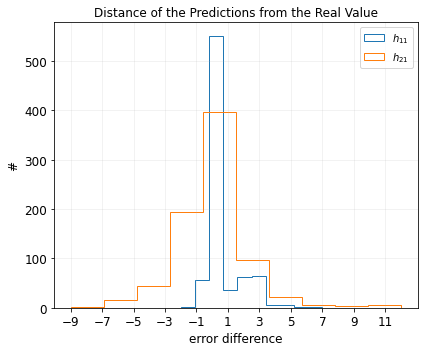

2020-05-19 10:19:01,155: DEBUG ==> Plot saved to ./img/original/svr_lv1_error.pdf.


In [14]:
from sklearn.svm      import SVR
from skopt            import BayesSearchCV
from skopt.space      import Integer, Real, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Trainining svr (Gaussian kernel)...')

rounding      = np.rint #---------------------------------------------------------- choose a rounding function
n_iter        = 50 #--------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'shrinking': Integer(0, 1),
                 'epsilon':   Real(1.0e-2, 1.0e2, prior='log-uniform'),
                 'C':         Real(1.0e0, 1.0e3,  prior='log-uniform'),
                 'gamma':     Real(1.0e-3, 1.0e3, prior='log-uniform')
                } #---------------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(SVR(kernel='rbf', max_iter=1e5), #------------------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

estimator.fit(feat_h11_train_lv1, h11_train_lv1) #----------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

svr_rbf_preds_h11   = estimator.best_estimator_.predict(feat_h11_train_lv2) #-------------------- compute predictions for h11 (lv2)
svr_rbf_test_preds_h11   = estimator.best_estimator_.predict(feat_h11_test) #-------------------- compute predictions for h11 (test)
pred_score_h11  = Score(y_true=h11_test, y_pred=svr_rbf_test_preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_train_lv1, h21_train_lv1) #----------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

svr_rbf_preds_h21   = estimator.best_estimator_.predict(feat_h21_train_lv2) #-------------------- compute predictions for h21 (lv2)
svr_rbf_test_preds_h21   = estimator.best_estimator_.predict(feat_h21_test) #-------------------- compute predictions for h21 (test)
pred_score_h21  = Score(y_true=h21_test, y_pred=svr_rbf_test_preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=1) #----------------------------------------------------------------- plot the comparison of the predictions

plot.hist2D(pred_score_h11.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'svr_lv1_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'svr_lv1_error.pdf')))

### [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

We then move to a different kind of decision tree algorithm and train a random forest of trees on the dataset.  In this case the hyperparameter space we explore is:

- `n_estimators` $\in \left[ 5, 75 \right]$,
- `criterion` $\in \lbrace mse, mae \rbrace$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_split` $\in \left[ 2, 100 \right]$,
- `min_samples_leaf` $\in \left[ 1, 100 \right]$,
- `min_weight_fraction_leaf` $\in \left[ 0, \frac{1}{2} \right]$,
- `max_leaf_nodes` $\in \left[ 2, 100 \right]$.

2020-05-19 10:19:01,174: INFO ==> Trainining random forest...



Best parameters for h11:

    criterion = mae
    max_depth = 50
    max_leaf_nodes = 61
    min_samples_leaf = 1
    min_samples_split = 2
    min_weight_fraction_leaf = 0.0
    n_estimators = 75

Accuracy of the cross-validation: 62.174% ± 0.792%
Accuracy of the predictions: 61.323%

Best parameters for h21:

    criterion = mae
    max_depth = 86
    max_leaf_nodes = 100
    min_samples_leaf = 1
    min_samples_split = 2
    min_weight_fraction_leaf = 0.0
    n_estimators = 75

Accuracy of the cross-validation: 17.157% ± 0.597%
Accuracy of the predictions: 18.066%


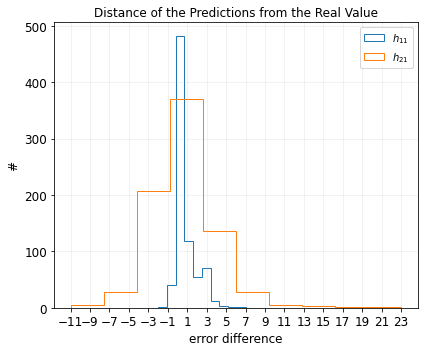

2020-05-19 16:42:10,488: DEBUG ==> Plot saved to ./img/original/rnd_for_lv1_error.pdf.


In [15]:
from sklearn.ensemble import RandomForestRegressor
from skopt            import BayesSearchCV
from skopt.space      import Integer, Real, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Trainining random forest...')

rounding      = np.floor #------------------------------------------------------------------- choose a rounding function
n_iter        = 20 #------------------------------------------------------------------------- the number of iteration of the Bayes search
search_params = {'n_estimators':             Integer(5, 75,  prior='uniform'),
                 'max_depth':                Integer(2, 100, prior='uniform'),
                 'min_samples_split':        Integer(2, 100, prior='uniform'),
                 'min_samples_leaf':         Integer(1, 100, prior='uniform'),
                 'max_leaf_nodes':           Integer(2, 100, prior='uniform'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
                 'criterion':                Categorical(['mse', 'mae'])
                } #-------------------------------------------------------------------------- define the hyperparameter optimization space
estimator     = BayesSearchCV(RandomForestRegressor(random_state=RAND), #-------------------- choose the base estimator
                              search_spaces=search_params,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #----------------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

estimator.fit(feat_h11_train_lv1, h11_train_lv1) #----------------------------------------------- fit the estimator to h11

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

rnd_for_preds_h11   = estimator.best_estimator_.predict(feat_h11_train_lv2) #-------------------- compute predictions for h11 (lv2)
rnd_for_test_preds_h11   = estimator.best_estimator_.predict(feat_h11_test) #-------------------- compute predictions for h11 (test)
pred_score_h11  = Score(y_true=h11_test, y_pred=rnd_for_test_preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator.fit(feat_h21_train_lv1, h21_train_lv1) #----------------------------------------------- fit the estimator to h21

cv_score = ViewCV(estimator) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score.test_mean()*100,
                                                                     cv_score.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

rnd_for_preds_h21   = estimator.best_estimator_.predict(feat_h21_train_lv2) #-------------------- compute predictions for h21 (lv2)
rnd_for_test_preds_h21   = estimator.best_estimator_.predict(feat_h21_test) #-------------------- compute predictions for h21 (test)
pred_score_h21  = Score(y_true=h21_test, y_pred=rnd_for_test_preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=1) #----------------------------------------------------------------- plot the comparison of the predictions

plot.hist2D(pred_score_h11.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'rnd_for_lv1_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'rnd_for_lv1_error.pdf')))

## Neural Network

We import the models using the _inception-like_ architecture and let them train (we start from the weights used in the training for the complete set: at worst they are sufficiently asymmetric to provide a good initialization and at best they can speed up the training process).

In [65]:
from tensorflow.keras.models       import Model
from tensorflow.keras.layers       import Input, Conv2D, Dense, LeakyReLU, Dropout, ZeroPadding2D, BatchNormalization, Flatten, concatenate
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.models       import load_model
from tensorflow.keras.backend      import clear_session
from tensorflow.keras.callbacks    import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from mltools.libscore              import Score

# define a function to build a model
def scan_inception_model(input_shape,
                         model_name='inception_model',
                         learning_rate=0.01,
                         conv_layers=[32],
                         conv_padding='same',
                         conv_alpha=0.0,
                         fc_layers=[],
                         fc_alpha=0.0,
                         dropout=0.2,
                         full_dropout=0.0,
                         normalization=0.99,
                         last_relu=True,
                         out_name='output',
                         l1_reg=0.0,
                         l2_reg=0.0
                        ):
    '''
    Build a CNN 'scan-inception' model: scan over rows and columns and merge.
    
    Required arguments:
        input_size:    the size of the input tensor.
        
    Optional arguments:
        model_name:    the name of the model,
        learning_rate: the learning rate of the gradient descent,
        conv_layers:   a list-like object with the no. of filters for each 'inception' modules,
        conv_padding:  the padding to use for the convolutional scans,
        conv_alpha:    the slope of the LeakyReLU activation (ReLU if 0.0) of the convolution layers,
        fc_layers:     a list-like object with the no. of units for each hidden dense layer,
        fc_alpha:      the slope of the LeakyReLU activation (ReLU if 0.0) of the FC network,
        dropout:       the dropout rate (do not use dropout if <= 0.0),
        full_dropout:  use this dropout rate after every layer (disabled if <= 0.0),
        normalization: the momentum of the batch normalization (do not use normalization if <= 0.0),
        last_relu:     whether to use ReLU activation in the output layer (force positive output),
        out_name:      the name of the output layer,
        l1_reg:        the L1 kernel regularization factor,
        l2_reg:        the L2 kernel regularization factor.
        
    Returns:
        the compiled model.
    '''
    
    # define the regularizer
    regularizer = l1_l2(l1=l1_reg, l2=l2_reg) #--------------------------------------------- regularizer
 
    # build the model
    I = Input(shape=input_shape, name=model_name + '_input') #------------------------------ input layer
    if conv_padding == 'same':
        x = I
    else:
        x = ZeroPadding2D(padding=((0,3),(0,0)), data_format='channels_last')(I)
    
    # build convolutional layers
    for n in range(np.shape(conv_layers)[0]): #--------------------------------------------- loop through the conv. layers
        a = Conv2D(filters=conv_layers[n],
                   kernel_size=(x.shape[1],1),
                   padding=conv_padding,
                   kernel_regularizer=regularizer,
                   name=model_name + '_conv2d_rows_' + str(n)
                  )(x) #-------------------------------------------------------------------- add conv. layer over rows
        a = LeakyReLU(alpha=conv_alpha,
                      name=model_name + '_conv2d_rows_' + str(n) + '_activation'
                     )(a) #----------------------------------------------------------------- add activation
        b = Conv2D(filters=conv_layers[n],
                   kernel_size=(1,x.shape[2]),
                   padding=conv_padding,
                   kernel_regularizer=regularizer,
                   name=model_name + '_conv2d_columns_' + str(n)
                  )(x) #-------------------------------------------------------------------- add conv. layer over columns
        b = LeakyReLU(alpha=conv_alpha,
                      name=model_name + '_conv2d_columns_' + str(n) + '_activation'
                     )(b) #----------------------------------------------------------------- add activation
        
        x = concatenate([a, b],
                        name=model_name + '_concatenation_' + str(n)
                       ) if conv_padding == 'same' \
                         else concatenate([a, tf.einsum('bij...->bji...',b)], #------------- swap columns and rows
                                          name=model_name + '_concatenation_' + str(n)
                                         ) #------------------------------------------------ concatenate layers
        
        if normalization > 0.0:
            x = BatchNormalization(momentum=normalization,
                                   name=model_name + '_conv2d_' + str(n) + '_normalization'
                                  )(x) #---------------------------------------------------- add batch normalization (if requested)
        if full_dropout > 0.0:
            x = Dropout(rate=full_dropout,
                        name=model_name + '_conv2d_' + str(n) + '_full_dropout'
                       )(x) #--------------------------------------------------------------- add dropout (if requested)
        
    # add dropout
    if dropout > 0.0 and full_dropout <= 0.0:
        x = Dropout(rate=dropout,
                    name=model_name + '_dropout'
                   )(x) #------------------------------------------------------------------- add dropout (if requested)
        
    # flatten the output
    x = Flatten(name=model_name + '_flatten')(x) #------------------------------------------ flatten the output
    
    # build FC network
    for n in range(np.shape(fc_layers)[0]):
        x = Dense(units=fc_layers[n],
                  kernel_regularizer=regularizer,
                  name=model_name + '_fc_' + str(n)
                 )(x) #--------------------------------------------------------------------- add dense layers
        x = LeakyReLU(alpha=fc_alpha,
                      name=model_name + '_fc_' + str(n) + '_activation'
                     )(x) #----------------------------------------------------------------- add activation
        
        if normalization > 0.0:
            x = BatchNormalization(momentum=normalization,
                                   name=model_name + '_fc_' + str(n) + '_normalization'
                                  )(x) #---------------------------------------------------- add batch normalization (if requested)
        if full_dropout > 0.0:
            x = Dropout(rate=full_dropout,
                        name=model_name + '_fc_' + str(n) + '_full_dropout'
                       )(x) #--------------------------------------------------------------- add dropout (if requested)
        
    if last_relu: #------------------------------------------------------------------------- output layer
        F = Dense(1, activation='relu', name=model_name + '_' + out_name)(x)
    else:
        F = Dense(1, name=model_name + '_' + out_name)(x)
    
    # define the model
    model = Model(inputs=I, outputs=F, name=model_name)
    
    # compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error']
                 )
    
    # return the compiled model
    return model

# define a function to fit the model with the correct callbacks, etc.
def cnn_fit(model,
            X,
            y,
            X_val,
            y_val,
            batch_size=32,
            epochs=100,
            early_stopping=10,
            reduce_lr=5,
            verbose=0
           ):
    '''
    Fit the model.
    
    Required arguments:
        model:          the model to fit,
        X:              the training features,
        y:              the training labels,
        X_val:          the validation features,
        y_val:          the validation labels.
        
    Optional arguments:
        batch_size:     the size of the batch used in forward pass,
        epochs:         the number of epochs,
        early_stopping: patience of early stopping,
        reduce_lr:      patience to reduce learning rate,
        verbose:        verbosity level (debug)
    
    Returns:
        the fitted model, the history of the model.
    '''
    
    # clear the TF graph
    clear_session()
    
    # define callbacks
    callbacks = [EarlyStopping(monitor='val_mean_squared_error',
                               patience=early_stopping,
                               verbose=verbose,
                               restore_best_weights=True
                              ),
                 ReduceLROnPlateau(monitor='val_mean_squared_error',
                                   factor=0.3,
                                   patience=reduce_lr,
                                   verbose=verbose
                                  ),
                 ModelCheckpoint(filepath=path.join(MOD_PATH, model.name + '_stack.h5'),
                                 monitor='val_mean_squared_error',
                                 verbose=verbose,
                                 save_best_only=True,
                                 save_format='h5'
                                )
                ]
    
    # fit the model
    history = model.fit(x=X,
                        y=y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=(X_val, y_val)
                       )
    
    # return the fitted model and its history
    return model, history.history

We then create and train the models:

2020-05-19 22:31:32,996: INFO ==> Fitting the model for h11...
2020-05-19 23:30:21,734: INFO ==> Fitting the model for h21...


Accuracy of the lv2 predictions for h11: 98.019%
Accuracy of the test predictions for h11: 98.092%
Accuracy of the lv2 predictions for h21: 32.663%
Accuracy of the test predictions for h21: 32.570%


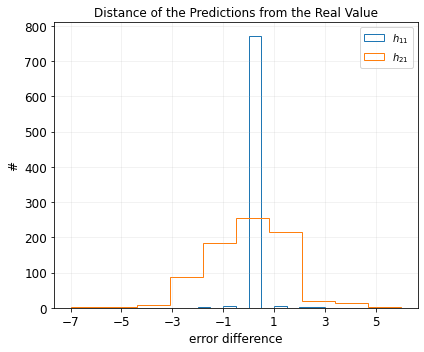

2020-05-20 01:04:06,441: DEBUG ==> Plot saved to ./img/original/neural_network_lv1_error.pdf.


In [66]:
# load the models
network_h11 = scan_inception_model(input_shape=matrix_train_lv1.shape[1:],
                                   model_name='h11_inception_same_conv_no_fc_stacking',
                                   learning_rate=1.0e-3,
                                   conv_layers=[32, 64, 32],
                                   conv_padding='same',
                                   conv_alpha=0.0,
                                   fc_layers=[],
                                   fc_alpha=0.0,
                                   dropout=0.3,
                                   full_dropout=0.0,
                                   normalization=0.99,
                                   last_relu=True,
                                   l1_reg=1.0e-4,
                                   l2_reg=1.0e-4
                                  )

network_h21 = scan_inception_model(input_shape=matrix_train_lv1.shape[1:],
                                   model_name='h21_inception_same_conv_no_fc_stacking',
                                   learning_rate=1.0e-3,
                                   conv_layers=[128, 128, 32],
                                   conv_padding='same',
                                   conv_alpha=0.0,
                                   fc_layers=[],
                                   fc_alpha=0.0,
                                   dropout=0.2,
                                   full_dropout=0.0,
                                   normalization=0.99,
                                   last_relu=True,
                                   l1_reg=1.0e-4,
                                   l2_reg=1.0e-4
                                  )

# fit the models
log.info('Fitting the model for h11...')
h11_model, h11_model_history = cnn_fit(network_h11,
                                       matrix_train_lv1,
                                       h11_matrix_train_lv1,
                                       matrix_val_lv1,
                                       h11_matrix_val_lv1,
                                       batch_size=32,
                                       epochs=5000,
                                       early_stopping=400,
                                       reduce_lr=250,
                                       verbose=0
                                      )
h11_model_predictions      = h11_model.predict(matrix_train_lv2).reshape(-1,)
h11_model_test_predictions = h11_model.predict(matrix_test).reshape(-1,)
h11_model_score            = Score(y_true=h11_train_lv2, y_pred=h11_model_predictions, rounding=np.rint)
h11_model_test_score       = Score(y_true=h11_test, y_pred=h11_model_test_predictions, rounding=np.rint)
print('Accuracy of the lv2 predictions for h11: {:.3f}%'.format(h11_model_score.accuracy()*100))
print('Accuracy of the test predictions for h11: {:.3f}%'.format(h11_model_test_score.accuracy()*100))

log.info('Fitting the model for h21...')
h21_model, h21_model_history = cnn_fit(network_h21,
                                       matrix_train_lv1,
                                       h21_matrix_train_lv1,
                                       matrix_val_lv1,
                                       h21_matrix_val_lv1,
                                       batch_size=32,
                                       epochs=5000,
                                       early_stopping=400,
                                       reduce_lr=250,
                                       verbose=0
                                      )
h21_model_predictions      = h21_model.predict(matrix_train_lv2).reshape(-1,)
h21_model_test_predictions = h21_model.predict(matrix_test).reshape(-1,)
h21_model_score            = Score(y_true=h21_train_lv2, y_pred=h21_model_predictions, rounding=np.rint)
h21_model_test_score       = Score(y_true=h21_test, y_pred=h21_model_test_predictions, rounding=np.rint)
print('Accuracy of the lv2 predictions for h21: {:.3f}%'.format(h21_model_score.accuracy()*100))
print('Accuracy of the test predictions for h21: {:.3f}%'.format(h21_model_test_score.accuracy()*100))

plot = Plot(rows=1, columns=1)

plot.hist2D(h11_model_test_score.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(h21_model_test_score.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'neural_network_lv1_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'neural_network_lv1_error.pdf')))

## Second Level Training

We then stack the predictions we obtained from the first level training and train a **meta estimator** on the newly produced dataset.

In [67]:
# stack second level predictions
h11_new_feat = np.c_[el_net_preds_h11, svr_rbf_preds_h11, rnd_for_preds_h11, h11_model_predictions]
h21_new_feat = np.c_[el_net_preds_h21, svr_rbf_preds_h21, rnd_for_preds_h21, h21_model_predictions]

# stack test predictions
h11_new_test_feat = np.c_[el_net_test_preds_h11, svr_rbf_test_preds_h11, rnd_for_test_preds_h11, h11_model_test_predictions]
h21_new_test_feat = np.c_[el_net_test_preds_h21, svr_rbf_test_preds_h21, rnd_for_test_preds_h21, h21_model_test_predictions]

## [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

We then use a **L1** regularized version of linear regression as a **meta** learner. In this case we will control a slightly higher number of hyperparameters:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-6}, 10^{-1} \right]$,
- `positive` $\in \lbrace 0, 1 \rbrace$.

2020-05-20 01:04:06,482: INFO ==> Trainining lasso (as meta learner)...



Best parameters for h11:

    alpha = 0.23070630983702106
    fit_intercept = 0
    normalize = 1
    positive = 1

Accuracy of the cross-validation: 98.132% ± 0.423%
Accuracy of the predictions: 98.219%

Best parameters for h21:

    alpha = 0.30019244855618826
    fit_intercept = 1
    normalize = 0
    positive = 1

Accuracy of the cross-validation: 37.645% ± 1.927%
Accuracy of the predictions: 36.132%


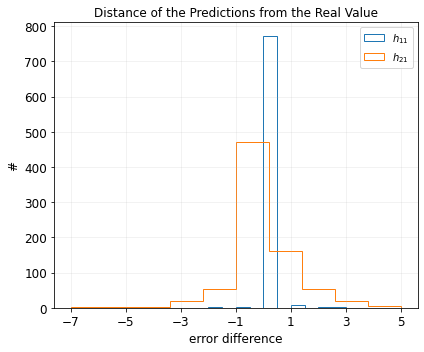

2020-05-20 01:07:44,125: DEBUG ==> Plot saved to ./img/original/lasso_lv2_error.pdf.


In [68]:
from sklearn.linear_model import Lasso
from skopt                import BayesSearchCV
from skopt.space          import Integer, Real, Categorical
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Trainining lasso (as meta learner)...')

rounding      = np.rint #---------------------------------------------------------- choose a rounding function
n_iter        = 50 #--------------------------------------------------------------- the number of iteration of the Bayes search
search_params_h11 = {'fit_intercept': Integer(0, 1),
                     'normalize':     Integer(0, 1),
                     'positive':      Integer(0, 1),
                     'alpha':         Real(1.0e-2, 1.0e1, prior='log-uniform')
                    } #---------------------------------------------------------------- define the hyperparameter optimization space
search_params_h21 = {'fit_intercept': Integer(0, 1),
                     'normalize':     Integer(0, 1),
                     'positive':      Integer(0, 1),
                     'alpha':         Real(1.0e-2, 1.0e2, prior='log-uniform')
                    } #---------------------------------------------------------------- define the hyperparameter optimization space
estimator_h11 = BayesSearchCV(Lasso(random_state=RAND, max_iter=1e5), #------------ choose the base estimator
                              search_spaces=search_params_h11,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )
estimator_h21 = BayesSearchCV(Lasso(random_state=RAND, max_iter=1e5), #------------ choose the base estimator
                              search_spaces=search_params_h21,
                              scoring=make_scorer(accuracy,
                                                  greater_is_better=True,
                                                  rounding=rounding
                                                 ), #------------------------------- create a custom scoring function (use accuracy after rounding)
                              n_jobs=n_jobs,
                              refit=True,
                              cv=cv
                             )

estimator_h11.fit(h11_new_feat, h11_train_lv2) #----------------------------------------------------- fit the estimator to h11

cv_score_h11 = ViewCV(estimator_h11) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h11:\n')
pretty(cv_score_h11.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score_h11.test_mean()*100,
                                                                     cv_score_h11.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

lasso_test_preds_h11   = estimator_h11.best_estimator_.predict(h11_new_test_feat) #---------------- compute predictions for h11 (test)
pred_score_h11  = Score(y_true=h11_test, y_pred=lasso_test_preds_h11, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ print test accuracy

estimator_h21.fit(h21_new_feat, h21_train_lv2) #----------------------------------------------------- fit the estimator to h21

cv_score_h21 = ViewCV(estimator_h21) #------------------------------------------------------------------- display CV scores
print('\nBest parameters for h21:\n')
pretty(cv_score_h21.best_parameters)
print('\nAccuracy of the cross-validation: {:.3f}% ± {:.3f}%'.format(cv_score_h21.test_mean()*100,
                                                                     cv_score_h21.test_std()*100
                                                                    ) #-------------------------- print CV accuracy
     )

lasso_test_preds_h21   = estimator_h21.best_estimator_.predict(h21_new_test_feat) #---------------- compute predictions for h21 (test)
pred_score_h21  = Score(y_true=h21_test, y_pred=lasso_test_preds_h21, rounding=rounding)
print('Accuracy of the predictions: {:.3f}%'.format(pred_score_h21.accuracy()*100)) #------------ print test accuracy

plot = Plot(rows=1, columns=1) #----------------------------------------------------------------- plot the comparison of the predictions

plot.hist2D(pred_score_h11.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{11}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )
plot.hist2D(pred_score_h21.error(),
            title='Distance of the Predictions from the Real Value',
            legend='$h_{21}$',
            xlabel='error difference',
            ylabel='#',
            binstep=2
           )

plot.save_and_close(path.join(IMG_PATH, 'lasso_lv2_error'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'lasso_lv2_error.pdf')))

## Discussion and Conclusions

Even though the algorithms are quite diverse in nature, they tend to have overlapping regions of _good performance_ (they all perform best in the central region of `num_cp`, for example) and the stacked ensemble cannot really exploit their differences to improve the results. Instead it starts to suffer from not having the entire set for training (also in the reference paper they mention a drop in accuracy when taking less samples in the training set).